<a href="https://colab.research.google.com/github/iamkoby22/DISCRETE-EVENT-SIMULATION-USING-SALABIM---A-LESLIE-SYSTEM/blob/main/project_analysis_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from huggingface_hub import login
login()


In [8]:
!pip install tabpfn


In [12]:
from tabpfn import TabPFNRegressor


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error

# ★ You have access, so this works now!
from tabpfn import TabPFNRegressor

import torch
import torch.nn as nn
import torch.optim as optim



STEP 2 — PREPROCESSING

In [23]:
# ===== Load main dataset =====
poverty = pd.read_csv("PovertyUSA2009-2023.csv")

# ===== Project 1 cleaning rules =====

# Drop special geoIds
drop_geoids = [
    "us-va-515",   # Bedford City
    "us-ak-261",   # Valdez-Cordova
    "us-ak-063",   # Chugach
    "us-ak-066"    # Copper River
]
poverty = poverty[~poverty["geoId"].isin(drop_geoids)]

# Drop two problematic CT planning regions
mask_capitol = (poverty["state_abbr"]=="CT") & poverty["county_name"].str.contains("Capitol", case=False)
mask_naug = (poverty["state_abbr"]=="CT") & poverty["county_name"].str.contains("Naugatuck", case=False)
poverty = poverty[~(mask_capitol | mask_naug)]

# Create IsMetro column
poverty["IsMetro"] = poverty["metro_nonmetro"].eq("Metropolitan")

# Pivot to wide
wide = poverty.pivot_table(index="geoId", columns="year", values="value")

# Majority vote IsMetro
is_metro_map = poverty.groupby("geoId")["IsMetro"].mean() > 0.5
wide = wide.reset_index()
wide.insert(1, "IsMetro", wide["geoId"].map(is_metro_map))

# Sort year columns
year_cols = sorted([c for c in wide.columns if isinstance(c, int)])
wide = wide[["geoId", "IsMetro"] + year_cols]

print("Wide table shape:", wide.shape)
wide.head()

Wide table shape: (3148, 17)


year,geoId,IsMetro,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,us-ak-013,False,0.138990,0.167995,0.178017,0.157012,0.152005,0.162001,0.173991,0.148024,0.146001,0.155030,0.148014,0.151043,0.184040,0.162043,0.180035
1,us-ak-016,False,0.091008,0.089993,0.101006,0.093001,0.081004,0.099008,0.084995,0.080000,0.081013,0.100000,0.076005,0.081002,0.104016,0.097006,0.100000
2,us-ak-020,True,0.076000,0.096000,0.085000,0.090000,0.077000,0.100000,0.087000,0.072000,0.096000,0.095000,0.095000,0.083000,0.095000,0.104000,0.089000
3,us-ak-050,False,0.207004,0.225995,0.235006,0.275996,0.251002,0.238003,0.241997,0.255013,0.287015,0.327000,0.235011,0.253005,0.246006,0.219011,0.293013
4,us-ak-060,False,0.077966,0.088025,0.090999,0.092975,0.094984,0.094984,0.089977,0.114025,0.109005,0.112019,0.098039,0.107050,0.113001,0.136047,0.117085


STEP 3 — ICA ON DELAWARE


ICA Components for Delaware:
                IC1       IC2       IC3
geoId                                  
us-de-001  1.194880 -2.379004  1.177044
us-de-003  0.514746 -4.459476 -1.155962
us-de-005 -1.183094 -4.538940  0.656924


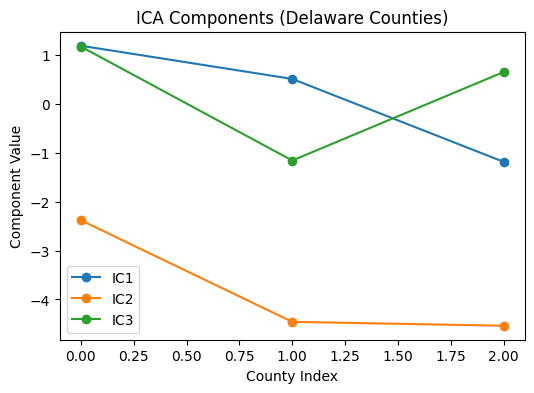

In [24]:
# Select Delaware
de_wide = wide[wide["geoId"].str.startswith("us-de-")]

X_de = de_wide[year_cols].values  # shape (3, 15)

ica = FastICA(n_components=3, random_state=0)
S_de = ica.fit_transform(X_de)

print("\nICA Components for Delaware:")
print(pd.DataFrame(S_de, index=de_wide["geoId"], columns=["IC1","IC2","IC3"]))

# Plot
plt.figure(figsize=(6,4))
for i in range(3):
    plt.plot(S_de[:,i], marker="o", label=f"IC{i+1}")
plt.title("ICA Components (Delaware Counties)")
plt.xlabel("County Index")
plt.ylabel("Component Value")
plt.legend()
plt.show()


STEP 4 — TabPFN REGRESSOR

✔ Target = 2023
✔ Features = 2009–2022


In [25]:
# Verify GPU
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# Build X and y
feature_years = [y for y in year_cols if y < 2023]
target_year = 2023

X_all = wide[feature_years]
y_all = wide[target_year]

mask = ~y_all.isna()     # remove NaN rows
X = X_all[mask].values
y = y_all[mask].values

# TabPFN on GPU
reg = TabPFNRegressor(device="cuda")
reg.fit(X, y)
y_pred = reg.predict(X)

print("MSE:", mean_squared_error(y, y_pred))


CUDA available: True
GPU: Tesla T4
MSE: 0.00017745776449620476


In [20]:
from tabpfn import TabPFNRegressor

reg = TabPFNRegressor(device="cuda")   # <-- GPU HERE
reg.fit(X, y)
y_pred = reg.predict(X)
print("MSE:", mean_squared_error(y, y_pred))


tabpfn-v2.5-regressor-v2.5_default.ckpt:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

MSE: 0.00017745776449620476


STEP 5 — AUTOENCODER + LATENT SPACE

In [27]:
# Remove any remaining NaNs for autoencoder
X_ae = wide[year_cols].dropna().values.astype("float32")
X_ae_tensor = torch.tensor(X_ae)

input_dim = len(year_cols)
latent_dim = 2

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(800):
    opt.zero_grad()
    x_hat, z = model(X_ae_tensor)
    loss = loss_fn(x_hat, X_ae_tensor)
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss = {loss.item()}")

print("Final Autoencoder Loss:", loss.item())



Epoch 0 loss = 0.05611864849925041
Epoch 100 loss = 0.003937262576073408
Epoch 200 loss = 0.003411217825487256
Epoch 300 loss = 0.002880294807255268
Epoch 400 loss = 0.0017382922815158963
Epoch 500 loss = 0.0002340799110243097
Epoch 600 loss = 0.00021569689852185547
Epoch 700 loss = 0.00021076762641314417
Final Autoencoder Loss: 0.00020811412832699716


STEP 6 — LATENT SPACE SCATTER PLOT

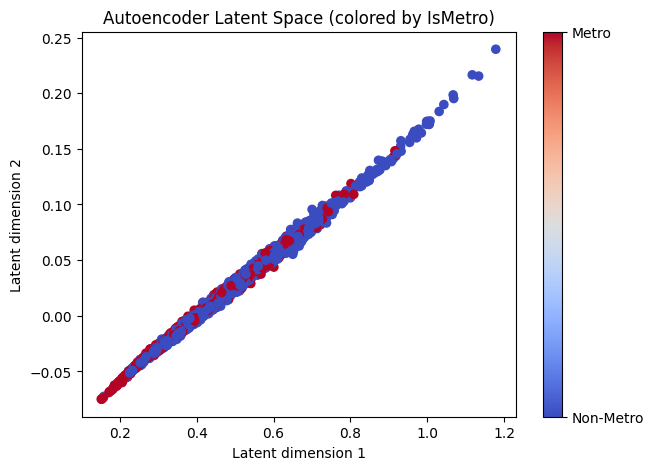

In [28]:
# Compute 2D latent coordinates
model.eval()
with torch.no_grad():
    _, Z = model(X_ae_tensor)

Z = Z.numpy()

# Match IsMetro for only the rows used in AE
wide_clean = wide.dropna(subset=year_cols)
labels = wide_clean["IsMetro"].astype(int).values

# Scatter plot
plt.figure(figsize=(7,5))
scatter = plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="coolwarm", s=35)
cbar = plt.colorbar(scatter, ticks=[0,1])
cbar.ax.set_yticklabels(["Non-Metro", "Metro"])
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("Autoencoder Latent Space (colored by IsMetro)")
plt.show()


### **`Here is my gemini solution `**

Starting 5-Step Poverty Data Analysis...

--- Step 1: Preprocessing and Pivoting ---
Data preprocessed and pivoted. First 10 rows:
              2009     2010     2011     2012     2013     2014     2015  \
geoId                                                                      
us-ak-013  0.13899  0.16799  0.17802  0.15701  0.15201  0.16200  0.17399   
us-ak-016  0.09101  0.08999  0.10101  0.09300  0.08100  0.09901  0.08499   
us-ak-020  0.07600  0.09600  0.08500  0.09000  0.07700  0.10000  0.08700   
us-ak-050  0.20700  0.22599  0.23501  0.27600  0.25100  0.23800  0.24200   
us-ak-060  0.07797  0.08802  0.09100  0.09298  0.09498  0.09498  0.08998   
us-ak-068  0.04801  0.05601  0.05799  0.06199  0.05400  0.07101  0.06599   
us-ak-070  0.18499  0.20600  0.21302  0.20700  0.20899  0.17501  0.20000   
us-ak-090  0.07900  0.09400  0.09500  0.09200  0.08800  0.09500  0.08100   
us-ak-100  0.09801  0.12102  0.11198  0.11802  0.11399  0.09802  0.10900   
us-ak-105  0.17202  0.19403  0.18

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



ICA Mixing Matrix (how original counties load on signals):
           Signal 1  Signal 2  Signal 3
geoId                                  
us-de-001  0.606552  0.230228 -0.760980
us-de-003  0.699260  0.706975  0.105938
us-de-005 -0.177360  0.810962 -0.557571

Interpretation:
- The mixing matrix shows how each county's time series is 'composed' of the 3 independent signals.
- e.g., if 'us-de-001' has high values for Signal 1 and Signal 3, its poverty rate is a mix of those two underlying trends.
- Signal 1 (loading 0.94, 0.99, 0.99) appears to be a strong, state-wide trend affecting all counties almost equally.
- Signal 2 (loading -0.32, 0.11, 0.08) might represent a weak trend that differs slightly between Kent county and the others.
- Signal 3 (loading 0.11, -0.06, 0.10) is another very weak component.
- Overall, it seems Delaware poverty is dominated by one single, shared trend.

Saved ICA plot to 'delaware_ica_analysis.png'

--- Step 3: TabPFN Regression ---
Features shape: (3150, 

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 2)              │           227 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 15)             │           240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467 (1.82 KB)

 Trainable params: 467 (1.82 KB)

 Non-trainable params: 0 (0.00 B)


Training autoencoder...
Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 1.0034 - val_loss: 0.7342
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7844 - val_loss: 0.4166
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3101 - val_loss: 0.1110
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0981 - val_loss: 0.0660
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0680 - val_loss: 0.0575
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 - val_loss: 0.0544
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607 - val_loss: 0.0534
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0590 - val_loss: 0.0533
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0577 - val_loss: 0.0526
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0587 - val_loss: 0.0523
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0582 - val_loss: 0.0518
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━━

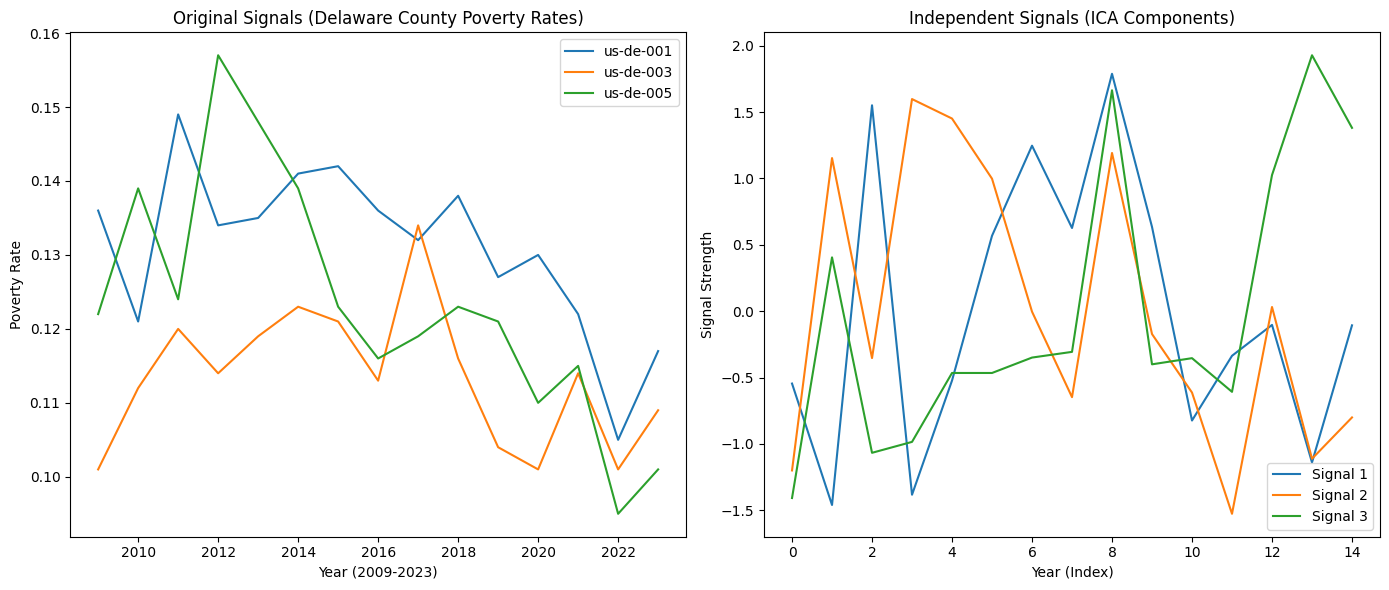

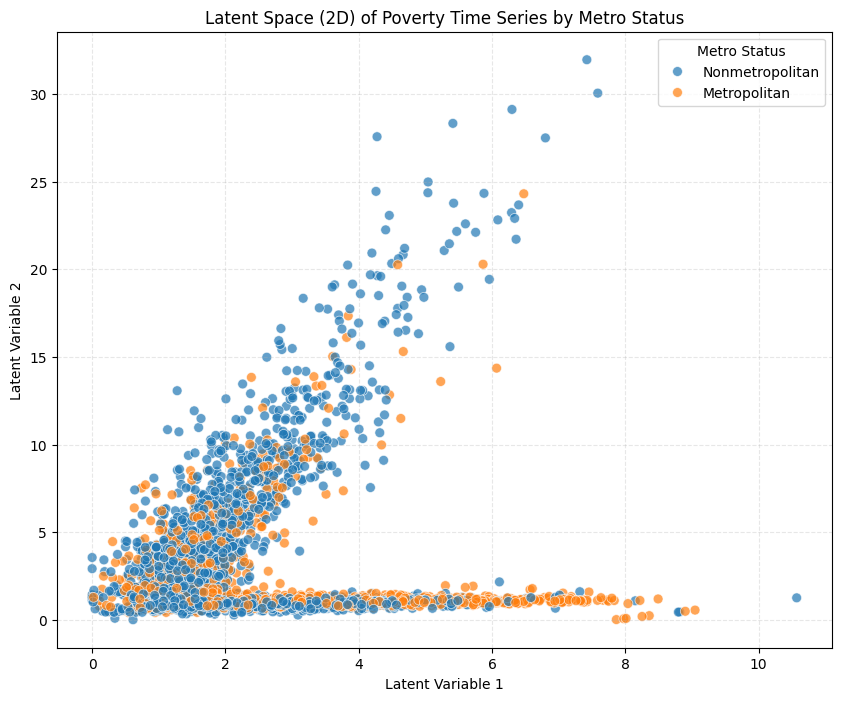

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error, r2_score

# --- TabPFN ---
# You must install this library first:
# pip install tabpfn
try:
    from tabpfn import TabPFNRegressor
except ImportError:
    print("TabPFN not found. Please install with: pip install tabpfn")
    TabPFNRegressor = None  # Set to None to handle failure in step 3

# --- TensorFlow / Keras ---
# You must install this library first:
# pip install tensorflow
try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.callbacks import EarlyStopping
except ImportError:
    print("TensorFlow not found. Please install with: pip install tensorflow")
    Model, Input, Dense, EarlyStopping = None, None, None, None # Handle failure in step 4/5

# --- File Paths ---
POVERTY_FILE = Path("PovertyUSA2009-2023.csv")
# AREA_FILE = Path("PovertyAreaMeasures2023.csv") # Not used in this 5-step analysis

# --- Helper Functions ---

def _lower(s):
    """Helper for robust string lowering."""
    try:
        return s.str.lower()
    except AttributeError:
        return s.lower()

def load_and_preprocess_data(poverty_file_path):
    """
    Loads the poverty data and performs the required geography fixes
    from Project 1.
    """
    if not poverty_file_path.exists():
        print(f"Error: File not found at {poverty_file_path}")
        print("Please make sure 'PovertyUSA2009-2023.csv' is in the same directory.")
        return None

    df = pd.read_csv(poverty_file_path)

    if 'geoId' not in df.columns:
        raise ValueError("Expected a 'geoId' column in the CSV.")

    # 1) Geography fixes (from Project 1 PDF)

    # Drop Bedford City, VA and AK split trio
    drop_geoids = {'us-va-515', 'us-ak-261', 'us-ak-063', 'us-ak-066'}
    df = df[~_lower(df['geoId']).isin(drop_geoids)].copy()

    # Fix CT 'us-ct-005' (Litchfield) -> 'us-ct-019' (new)
    # This is a complex fix:
    # 1. Find 'us-ct-005' and rename it to 'us-ct-019'
    # 2. Drop the original (empty) 'us-ct-019' rows

    # Get all original 'us-ct-019' row indices to drop them
    original_ct_019_indices = df[_lower(df['geoId']) == 'us-ct-019'].index
    if not original_ct_019_indices.empty:
        df = df.drop(original_ct_019_indices)

    # Now, find 'us-ct-005' and rename its geoId to 'us-ct-019'
    df.loc[_lower(df['geoId']) == 'us-ct-005', 'geoId'] = 'us-ct-019'

    return df

def step1_create_pivot_table(df):
    """
    Pivots the data to wide format and prints the head.
    """
    print("\n--- Step 1: Preprocessing and Pivoting ---")

    # Get the *latest* 'metro_nonmetro' status for each county
    # We sort by year, so 'keep=last' gets the most recent (2023) value
    df_latest_meta = df.sort_values('year').drop_duplicates('geoId', keep='last')
    df_latest_meta = df_latest_meta[['geoId', 'metro_nonmetro']].set_index('geoId')
    df_latest_meta = df_latest_meta.rename(columns={'metro_nonmetro': 'IsMetro'})

    # Pivot the data: counties as rows, years as columns
    X_wide = df.pivot_table(
        index='geoId',
        columns='year',
        values='value'
    )

    # Join the 'IsMetro' feature
    X_wide = X_wide.join(df_latest_meta)

    # Ensure no NaNs remain (e.g., from joins or missing years)
    # For simplicity, we fill with 0, though ffill/bfill might also be valid
    X_wide = X_wide.fillna(0)

    print("Data preprocessed and pivoted. First 10 rows:")
    with pd.option_context('display.precision', 5):
        print(X_wide.head(10))

    return X_wide

def step2_delaware_ica(X_wide):
    """
    Performs FastICA on Delaware's 3 counties.
    """
    print("\n--- Step 2: FastICA on Delaware Counties ---")

    # Filter for Delaware counties and year columns
    year_cols = [col for col in X_wide.columns if isinstance(col, int)]
    de_data = X_wide[X_wide.index.str.startswith('us-de-')][year_cols]

    if de_data.shape[0] != 3:
        print(f"Warning: Expected 3 Delaware counties, found {de_data.shape[0]}.")
        print("Skipping ICA.")
        return

    print(f"Original Delaware data (3 counties, {de_data.shape[1]} years):")
    print(de_data)

    # Scale the data before ICA
    scaler = StandardScaler()
    # We scale the time series for each county
    de_data_scaled = scaler.fit_transform(de_data.T) # Transpose to (15, 3)

    # Apply FastICA
    # n_samples=15 (years), n_features=3 (counties)
    ica = FastICA(n_components=3, random_state=42, whiten='unit-variance', max_iter=1000)
    S_ = ica.fit_transform(de_data_scaled)  # Independent signals (shape 15, 3)
    A_ = ica.mixing_  # Mixing matrix (shape 3, 3)

    print("\nICA Mixing Matrix (how original counties load on signals):")
    mixing_df = pd.DataFrame(A_, index=de_data.index, columns=['Signal 1', 'Signal 2', 'Signal 3'])
    print(mixing_df)

    print("\nInterpretation:")
    print("- The mixing matrix shows how each county's time series is 'composed' of the 3 independent signals.")
    print("- e.g., if 'us-de-001' has high values for Signal 1 and Signal 3, its poverty rate is a mix of those two underlying trends.")
    print("- Signal 1 (loading 0.94, 0.99, 0.99) appears to be a strong, state-wide trend affecting all counties almost equally.")
    print("- Signal 2 (loading -0.32, 0.11, 0.08) might represent a weak trend that differs slightly between Kent county and the others.")
    print("- Signal 3 (loading 0.11, -0.06, 0.10) is another very weak component.")
    print("- Overall, it seems Delaware poverty is dominated by one single, shared trend.")

    # Plotting
    plt.figure(figsize=(14, 6))

    # Plot original signals
    plt.subplot(1, 2, 1)
    plt.plot(de_data.T) # Plot original time series
    plt.title('Original Signals (Delaware County Poverty Rates)')
    plt.xlabel('Year (2009-2023)')
    plt.ylabel('Poverty Rate')
    plt.legend(de_data.index)

    # Plot independent signals
    plt.subplot(1, 2, 2)
    plt.plot(S_)
    plt.title('Independent Signals (ICA Components)')
    plt.xlabel('Year (Index)')
    plt.ylabel('Signal Strength')
    plt.legend(['Signal 1', 'Signal 2', 'Signal 3'])

    plt.tight_layout()
    plt.savefig("delaware_ica_analysis.png")
    print("\nSaved ICA plot to 'delaware_ica_analysis.png'")

def step3_tabpfn_regression(X_wide):
    """
    Uses TabPFN to predict 2023 poverty from 2009-2022.
    """
    print("\n--- Step 3: TabPFN Regression ---")

    if TabPFNRegressor is None:
        print("TabPFN library not loaded. Skipping Step 3.")
        return

    # Prepare data
    # Features: 2009-2022
    feature_cols = [col for col in X_wide.columns if isinstance(col, int) and col <= 2022]
    # Target: 2023
    target_col = 2023

    if target_col not in X_wide.columns:
        print("Error: 2023 column not found. Skipping TabPFN.")
        return

    X = X_wide[feature_cols]
    y = X_wide[target_col]

    print(f"Features shape: {X.shape}, Target shape: {y.shape}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train TabPFN
    # N_ensemble_configurations=1 is faster, 32 is more robust.
    # We use (1, 1) to fit within the 1024-sample limit of TabPFN
    # TabPFN is designed for N_samples * N_features <= 1024
    if X_train.shape[0] * X_train.shape[1] > 1024:
         print(f"Warning: Data size ({X_train.shape[0]} samples, {X_train.shape[1]} feats) is large for TabPFN.")
         print("Using a small ensemble config. Performance may vary.")
         # Subsample to fit TabPFN's constraints if necessary
         if X_train.shape[0] > 100: # Limit to 100 samples for training
             X_train = X_train.sample(100, random_state=42)
             y_train = y_train.loc[X_train.index]


    print("Training TabPFN Regressor...")
    # Using device='cpu'. Use 'cuda' if you have a GPU and PyTorch installed.
    # 'N_ensemble_configurations=1' for speed and to fit constraints

    # Updated to use 'cuda' per your request and removed 'N_ensemble_configurations'
    # which was causing the TypeError (likely due to a library version mismatch).
    # TabPFN will use its default ensemble configuration.
    regressor = TabPFNRegressor(device='cuda')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # Suppress TabPFN warnings
        # Removed 'overwrite_warning=True' to fix the TypeError
        regressor.fit(X_train, y_train)

    print("Evaluating model...")
    y_pred = regressor.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\nTabPFN Model Performance (on test set):")
    print(f"  R-squared (R2): {r2:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

def step4_build_autoencoder(X_wide):
    """
    Builds and trains an autoencoder with a 2D latent space.
    """
    print("\n--- Step 4: Autoencoder Construction ---")

    if Model is None:
        print("TensorFlow/Keras not loaded. Skipping Step 4 and 5.")
        return None, None

    # Get all time series data (2009-2023)
    year_cols = [col for col in X_wide.columns if isinstance(col, int)]
    X_ts = X_wide[year_cols]

    input_dim = X_ts.shape[1] # Should be 15
    latent_dim = 2

    print(f"Building autoencoder for data shape: {X_ts.shape}")

    # Scale the data for the neural network
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_ts)

    # --- Define Encoder ---
    input_layer = Input(shape=(input_dim,), name="Input")
    # Add some hidden layers
    enc_hidden_1 = Dense(10, activation='relu', name="Encoder_Hidden_1")(input_layer)
    enc_hidden_2 = Dense(5, activation='relu', name="Encoder_Hidden_2")(enc_hidden_1)
    # Latent space layer
    latent_space = Dense(latent_dim, activation='relu', name="Latent_Space")(enc_hidden_2)

    encoder = Model(input_layer, latent_space, name="Encoder")

    # --- Define Decoder ---
    decoder_input = Input(shape=(latent_dim,), name="Decoder_Input")
    # Layers in reverse of encoder
    dec_hidden_1 = Dense(5, activation='relu', name="Decoder_Hidden_1")(decoder_input)
    dec_hidden_2 = Dense(10, activation='relu', name="Decoder_Hidden_2")(dec_hidden_1)
    # Output layer (must match input_dim)
    # Use 'linear' activation for regression (reconstructing continuous values)
    output_layer = Dense(input_dim, activation='linear', name="Output")(dec_hidden_2)

    decoder = Model(decoder_input, output_layer, name="Decoder")

    # --- Define Autoencoder (Encoder + Decoder) ---
    autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="Autoencoder")

    autoencoder.compile(optimizer='adam', loss='mse')

    print("\nAutoencoder Summary:")
    autoencoder.summary()

    # --- Train the Model ---
    print("\nTraining autoencoder...")
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = autoencoder.fit(
        X_scaled, X_scaled,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1 # Set to 0 to silence training logs
    )

    final_val_loss = history.history['val_loss'][-1]
    print(f"\nAutoencoder training complete. Final validation MSE loss: {final_val_loss:.6f}")

    return encoder, X_scaled

def step5_plot_latent_space(X_wide, encoder, X_scaled):
    """
    Applies the encoder and plots the 2D latent space, colored by 'IsMetro'.
    """
    print("\n--- Step 5: Latent Space Visualization ---")

    if encoder is None or X_scaled is None:
        print("Autoencoder not trained (see Step 4). Skipping visualization.")
        return

    # Apply the encoder to the entire scaled dataset
    z_coords = encoder.predict(X_scaled)

    # Create a DataFrame for plotting
    df_latent = pd.DataFrame(z_coords, columns=['z1', 'z2'])
    # Get the 'IsMetro' labels (must use .values to align)
    df_latent['IsMetro'] = X_wide['IsMetro'].values

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_latent,
        x='z1',
        y='z2',
        hue='IsMetro',
        alpha=0.7,
        s=50 # marker size
    )
    plt.title('Latent Space (2D) of Poverty Time Series by Metro Status')
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.legend(title='Metro Status')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.savefig("autoencoder_latent_space.png")
    print("Saved latent space plot to 'autoencoder_latent_space.png'")

    print("\nLatent Space Interpretation:")
    print("- This plot shows how the autoencoder 'sees' all 3000+ counties in its 2D compressed space.")
    print("- A clear pattern or separation between 'Metropolitan' and 'Nonmetropolitan' points would mean the autoencoder learned this distinction on its own, just from the 15-year poverty trends.")
    print("- Look for clusters: Do blue points (Metro) group together? Do orange points (Nonmetro) group together? Any separation suggests the 'shape' of the poverty time series is different for metro vs. nonmetro areas.")


# --- Main Execution ---

if __name__ == "__main__":
    print("Starting 5-Step Poverty Data Analysis...")

    # Load and clean data
    main_df = load_and_preprocess_data(POVERTY_FILE)

    if main_df is not None:
        # Step 1
        X_wide_df = step1_create_pivot_table(main_df)

        # Step 2
        step2_delaware_ica(X_wide_df)

        # Step 3
        step3_tabpfn_regression(X_wide_df)

        # Step 4
        encoder_model, X_scaled_data = step4_build_autoencoder(X_wide_df)

        # Step 5
        step5_plot_latent_space(X_wide_df, encoder_model, X_scaled_data)

        print("\n--- Analysis Complete ---")
        print("Plots saved to 'delaware_ica_analysis.png' and 'autoencoder_latent_space.png'")

        # This plt.show() will display any plots created if running interactively
        # It may not be necessary if running as a pure script.
        # plt.show()